# t-SNE Visuzalization Supernova Remnants Data.

I apply t-SNE technique (https://lvdmaaten.github.io/tsne/) to vizualize X-ray emission line data from Supernova Remnant sources observed by Suzaku telescope. 

In [61]:
import numpy as Math
import pylab as Plot

def Hbeta(D = Math.array([]), beta = 1.0):
        """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

        # Compute P-row and corresponding perplexity
        P = Math.exp(-D.copy() * beta);
        sumP = sum(P);
        H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
        P = P / sumP;
        return H, P;


def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
        """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

        # Initialize some variables
        print("Computing pairwise distances...")
        (n, d) = X.shape;
        sum_X = Math.sum(Math.square(X), 1);
        D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
        P = Math.zeros((n, n));
        beta = Math.ones((n, 1));
        logU = Math.log(perplexity);

        # Loop over all datapoints
        for i in range(n):

                # Print progress
                if i % 500 == 0:
                        print("Computing P-values for point ", i, " of ", n, "...")

                # Compute the Gaussian kernel and entropy for the current precision
                betamin = -Math.inf;
                betamax =  Math.inf;
                Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
                (H, thisP) = Hbeta(Di, beta[i]);

                # Evaluate whether the perplexity is within tolerance
                Hdiff = H - logU;
                tries = 0;
                while Math.abs(Hdiff) > tol and tries < 50:

                        # If not, increase or decrease precision
                        if Hdiff > 0:
                                betamin = beta[i].copy();
                                if betamax == Math.inf or betamax == -Math.inf:
                                        beta[i] = beta[i] * 2;
                                else:
                                        beta[i] = (beta[i] + betamax) / 2;
                        else:
                                betamax = beta[i].copy();
                                if betamin == Math.inf or betamin == -Math.inf:
                                        beta[i] = beta[i] / 2;
                                else:
                                        beta[i] = (beta[i] + betamin) / 2;

                        # Recompute the values
                        (H, thisP) = Hbeta(Di, beta[i]);
                        Hdiff = H - logU;
                        tries = tries + 1;

                # Set the final row of P
                P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

        # Return final P-matrix
        print("Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta)));
        return P;


def pca(X = Math.array([]), no_dims = 50):
        """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

        print("Preprocessing the data using PCA...")
        (n, d) = X.shape;
        X = X - Math.tile(Math.mean(X, 0), (n, 1));
        (l, M) = Math.linalg.eig(Math.dot(X.T, X));
        Y = Math.dot(X, M[:,0:no_dims]);
        return Y;


def tsne(X = Math.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0):
        """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
        The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

        # Check inputs
        if isinstance(no_dims, float):
                print("Error: array X should have type float.");
                return -1;
        if round(no_dims) != no_dims:
                print("Error: number of dimensions should be an integer.");
                return -1;

        # Initialize variables
        X = pca(X, initial_dims).real;
        (n, d) = X.shape;
        max_iter = 1000;
        initial_momentum = 0.5;
        final_momentum = 0.8;
        eta = 500;
        min_gain = 0.01;
        Y = Math.random.randn(n, no_dims);
        dY = Math.zeros((n, no_dims));
        iY = Math.zeros((n, no_dims));
        gains = Math.ones((n, no_dims));

        # Compute P-values
        P = x2p(X, 1e-5, perplexity);
        P = P + Math.transpose(P);
        P = P / Math.sum(P);
        P = P * 4;                                                                      # early exaggeration
        P = Math.maximum(P, 1e-12);

        # Run iterations
        for iter in range(max_iter):

                # Compute pairwise affinities
                sum_Y = Math.sum(Math.square(Y), 1);
                num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
                num[list(range(n)), list(range(n))] = 0;
                Q = num / Math.sum(num);
                Q = Math.maximum(Q, 1e-12);

                # Compute gradient
                PQ = P - Q;
                for i in range(n):
                        dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);

                # Perform the update
                if iter < 20:
                        momentum = initial_momentum
                else:
                        momentum = final_momentum
                gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
                gains[gains < min_gain] = min_gain;
                iY = momentum * iY - eta * (gains * dY);
                Y = Y + iY;
                Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

                # Compute current value of cost function
                if (iter + 1) % 10 == 0:
                        C = Math.sum(P * Math.log(P / Q));
#                        print("Iteration ", (iter + 1), ": error is ", C)

                # Stop lying about P-values
                if iter == 100:
                        P = P / 4;

        # Return solution
        return Y;



In [64]:
import pandas as pd
lines = pd.read_pickle('for_sne.pkl')
X = lines.values
YY = [lines.index.levels[3].values[l] for l in lines.index.labels[3].values()] 
sources = [lines.index.levels[4].values[l] for l in lines.index.labels[4].values()] 
obsids = [lines.index.levels[1].values[l] for l in lines.index.labels[1].values()] 


In [65]:
Y = tsne(X,2,50,20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  408 ...
Mean value of sigma:  2.31481265322


# Plot in matplotlib

Not that pretty.

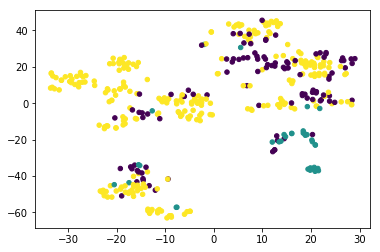

In [66]:
Plot.scatter(Y[:,0],Y[:,1],20,YY)
Plot.show()

# Bokeh Vizualization

Interactive: hovering over a point allows to see observation ID and the source. Green shows Type I and red shows Type II SNRs. Gray point are SNRs of unidentified type. 

In [70]:
from bokeh import mpl
from bokeh.charts import Histogram, output_notebook, show, ColumnDataSource, defaults
from bokeh.models import HoverTool
from bokeh.plotting import figure
#from bokeh.charts import output_notebook
cols = ["gray","green","red"]
colors = [cols[x] for x in  YY]
source = ColumnDataSource(data=dict(x=Y[:,0],y=Y[:,1],name=sources,obsid=obsids,color=colors))
hover = HoverTool(tooltips=[("Object","@name"),("Obsid","@obsid")])
p = figure(title="",width=800,x_range=[-50,50],y_range=[-50,50],height=600,tools=[hover,"pan","wheel_zoom","box_zoom","reset"])

p.xaxis.axis_label = "X"
p.yaxis.axis_label = "Y"

p.circle('x','y',color='color', fill_alpha=0.2,source=source,size=10)

output_notebook()
show(p)                          

Loading BokehJS ...